In [1]:
import time
__START = time.time()

# SWAP gate classifier Simulation Summary

## Basic idea

### Support Vector Machine:
By strong duality and KKT condition, finding seperating hyperplane is equivalent to solving dual problem below.
$$ \min_{\alpha\ge0}{\frac{C}{2}\sum_{i,j=1}^{N}{\alpha_i\alpha_jy_iy_jK(x_i, x_j)}-\sum_{i=1}^{N}{\alpha_i}} : \sum_{i=1}^{N}{\alpha_iy_i}=0, \alpha\le 1$$
and classification can be done by,
$$\hat{y} = sgn\left[\sum_{i=1}^{N}{\alpha_iy_iK(x_i, x)}\right]$$
assuming bias of primal problem $b\sim0$<br><br>
For quantum circuit implementation, we need to add more constraint, $\sum_{i=1}^{N}{\alpha_i}=1$ and $N=2^n$. Effect of these additional constraints is questionable.<br>
Also, Since **SWAP test** will be used as distance measurement, or more specifically, Fidelity, Kernel should be order of 2 polynomial kernel, $K(x, y)=|\left<x,y\right>|^2$.


### (uniform) SWAP classifier
We have optimizable SWAP classifier quatum circuit shown bellow.  
![qusvm.png](./figs/qusvm.png)<br>
Classifing equation is,
$$\hat{y} = sgn\left[\sum_{i=1}^{2^n}{\frac{1}{N}y_iK(x_i, x)}\right]$$

### (empirical) SWAP classifier
We have non-optimizable SWAP classifier quatum circuit shown bellow.  
![qesvm.png](./figs/qesvm.png)<br>
objective function is empirical risk loss function with cross entropy, that is,
$$ \min_{\alpha\ge0}{\frac{1}{2^n}\sum_{i=1}^{2^n}\mathcal{L}(y_i, \hat{y_i})}: \sum_{i=1}^{2^n}{\alpha_iy_i}=0, \sum_{i=1}^{2^n}{\alpha_i}=1, \hat{y_j} = \sigma\left(C\sum_{i=1}^{2^n}{\alpha_iy_iK(x_i, x_j)}\right)$$
$$\mathcal{L}(y, \hat{y})=-y\log{\hat{y}}-(1-y)\log{(1-\hat{y})}$$
and classifing equation is
$$\hat{y} = sgn\left[\sum_{i=1}^{2^n}{\alpha_iy_iK(x_i, x)}\right]$$

### (quadratic or general) SWAP classifier
We have optimizable SWAP classifier quatum circuit shown bellow.  
![qsvm.png](./figs/qsvm.png)<br>
objective function is simular form with classical SVM
$$ \min_{\alpha\ge0}{\frac{C}{2}\sum_{i,j=1}^{2^n}{\alpha_i\alpha_jy_iy_jK(x_i, x_j)}-\sum_{i=1}^{2^n}{\alpha_i}} : \sum_{i=1}^{2^n}{\alpha_iy_i}=0, \sum_{i=1}^{2^n}{\alpha_i}=1$$
and classifing equation is,
$$\hat{y} = sgn\left[\sum_{i=1}^{2^n}{\alpha_iy_iK(x_i, x)}\right]$$
Though out the simulation, the term *SWAP classifier* generally refers to quadratic SWAP classifier

## Implementation

For the sake of classical simulation speed, I've implemented models that only the weighting circuit is simulated as quantum circuit and other part is purly matrix multiplication. These mdels have the word 'peseudo' in their class names. The 'real' simulation of SWAP classifier quantum circuit is possible with other model, which have the word 'quantum' in their class names. Note that for quantum simulations, GPU accelaration is possible.

for more information, check 'classifier.py', 'swap_classifier.py', 'quantum_swap_classifier.py' and 'pesudo_swap_classifier.py' in repository [custum_qiskit](https://github.com/Siheon-Park/QUIC-Projects/tree/master/custom_qiskit)

## Usage

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 

from qiskit import Aer

from custom_qiskit.classifier import SVM
from custom_qiskit.quantum_swap_classifier import quantum_SWAP_classifier, quantum_uniform_SWAP_classifier
from custom_qiskit.pseudo_swap_classifier import pseudo_SWAP_classifier, pseudo_uniform_SWAP_classifier, pseudo_empirical_SWAP_classifier
from custom_qiskit.datageneration import sklearn_data

### Data generation
Data X, y is drawn randomly from the iris data and wind data in module **sklearn**. The number of data sample should be power of 2 ($N=2^n$) due to the leakage in $\alpha$.<br>
Total number of iris data is 150 and total number of wine data is 178, so remaining data are used as test data (Xt, yt).<br>
iris dataset is loaded from **sklearn** library, where label 0 is seperable from other labels, but label 1 and label 2 is not seperable with each ohters.<br>
wine dataset is loaded from **sklearn** library, where all labels are not seperable
<br><br>
In the example below, we are using seperable iris data


In [3]:
X, y, Xt, yt = sklearn_data('iris', 2**6, range(4), (0, 1), 'nb') # seperable
print(f'training data shape: {X.shape}')
print(f'test data shape: {Xt.shape}')

training data shape: (64, 4)
test data shape: (36, 4)


### Parametric circuit
Parametric quantum circuit(PQA) is essential for VQA. Here, PQA is used for weight amplitude encoding. training data are not encoded with PQA since they are stationary.<br>
The number of optimization parameter $\theta$ differ according to entangler ID and layers, but it is $\mathcal{O}(n)$, where as the number of classical SVM is $\mathcal{O}(2^n)$.<br>
Thus, there are some advantages with number of optimization variables in SWAP classifier.
<br><br>
In the example below, $\alpha$ is constructed by entangler id #2 with 5 layer. For more information, read [reference](https://arxiv.org/abs/1905.10876).

In [4]:
backend = Aer.get_backend('qasm_simulator') # or any valid backend provided by qiskit
svm = SVM(X, y, C=100) # C is large for hard margin problem
psvm = pseudo_SWAP_classifier(X, y, C=100, id=1, layer=5)
pesvm = pseudo_empirical_SWAP_classifier(X, y, C=100, id=1, layer=5)
pusvm = pseudo_uniform_SWAP_classifier(X, y)
qsvm = quantum_SWAP_classifier(X, y, C=100, id=1, layer=5, backend=backend, execute_option={'shots':10000})

### Calculation validation
Let's check pesudo SWAP classifier is equivalent with quantum SWAP classifier.
As shown in below, psvm and qsvm yields simular values for various calculations.

In [5]:
theta = np.random.rand(len(psvm.theta))
# compare objective function value for arbitrary param.
print('psvm obj func: {:.3f}, qsvm obj func: {:.3f}'.format(psvm.objective_function(theta), qsvm.objective_function(theta)))
# compare equality constraint, i.e. <IZZ>
print('psvm <IZZ>: {:.3f}, qsvm <IZZ>: {:.3f}'.format(psvm.equality_constraint(theta), qsvm.equality_constraint(theta)))
# classifing value for arbitrary test data, i.e. <ZZ>
_test_data = Xt[np.random.randint(len(yt)), :]
print('psvm <ZZ>: {:.3f}, qsvm <ZZ>: {:.3f}'.format(psvm.ZZval(theta, _test_data)[0], qsvm.ZZval(theta, _test_data)))

psvm obj func: 14.683, qsvm obj func: 14.970
psvm <IZZ>: 0.007, qsvm <IZZ>: 0.010
psvm <ZZ>: -0.256, qsvm <ZZ>: -0.245


### Optimization
with the help of **scipy** minimization, optimization is achieved. optimization algorithm is *SLSQP*.

In [45]:
svm.optimize(np.random.rand(svm.num_data), disp=True)
psvm.optimize(np.random.rand(len(psvm.theta)), disp=True)
pesvm.optimize(np.random.rand(len(psvm.theta)), disp=True)
# qsvm.optimize(np.random.rand(len(qsvm.theta)), disp=True) # this optimization is very time-consuming

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.03632743482080816
            Iterations: 15
            Function evaluations: 991
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.221573168197587
            Iterations: 36
            Function evaluations: 2288
            Gradient evaluations: 36
Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.156250788356447
            Iterations: 101
            Function evaluations: 6392
            Gradient evaluations: 101


### Plotting
There are Four options to plot resulting classifer. if keyword *option* is 'data', it simply plots training data with label. if 'alpha', then it simply plots optimized weight where x axis represent training data index. if 'sv', it shows support vectors(= data with weight greater than average weight) in black circle with whole training data with label. defalut *option* is 'sv'.<br>
Also, if word 'tsne' is in *option*, then it will plot TSNE transformed 2D data instead of original data. However, transformed data should be obtained with *self.tsne* method and stored in *self.data_emb* manually prior to the plotting. It is due to randomness in TSNE algorithm.<br><br>
Note that for Hard margin problem, parametric SWAP classifier performs exellent, sharing simular $\alpha$ with classical SVM, especially quadratic SWAP classifier.

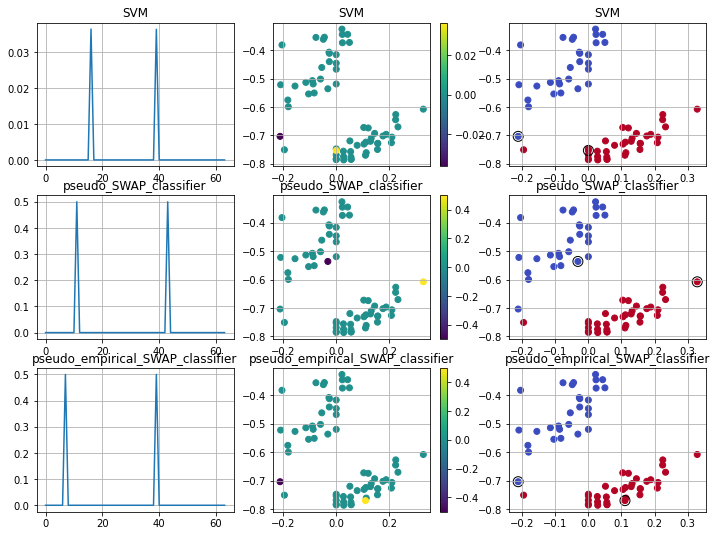

In [46]:
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
a=(1, 3) # index of dimention of data to show
svm.plot(axes=axes[0, 0], option='alpha', a=a)
psvm.plot(axes=axes[1, 0], option='alpha', a=a)
pesvm.plot(axes=axes[2, 0], option='alpha', a=a)
svm.plot(axes=axes[0, 1], option='density', a=a)
psvm.plot(axes=axes[1, 1], option='density', a=a)
pesvm.plot(axes=axes[2, 1], option='density', a=a)
svm.plot(axes=axes[0, 2], option='sv', a=a)
psvm.plot(axes=axes[1, 2], option='sv', a=a)
pesvm.plot(axes=axes[2, 2], option='sv', a=a)

### Classification & Evaluation
use *self.predict* method to get estimated label for test data.<br>
use *self.check_performance* to evaluate the model. This is just empirical correct probability<br><br>
Note that for evenly distributed data, uniform SWAP classifier usually performs well, but for the other case, it is absolutely terrible.

In [8]:
print('Empirical correct probability of')
print('\tclassical SVM:                    {:.3%}'.format(svm.check_performance(Xt, yt)))
print('\tSWAP gate classifier:             {:.3%}'.format(psvm.check_performance(Xt, yt)))
print('\tempirical SWAP gate classifier:   {:.3%}'.format(pesvm.check_performance(Xt, yt)))
print('\tUniform SWAP classifier:          {:.3%}'.format(pusvm.check_performance(Xt, yt)))
print('for iris dataset')

Empirical correct probability of
	classical SVM:                    100.000%
	SWAP gate classifier:             100.000%
	empirical SWAP gate classifier:   100.000%
	Uniform SWAP classifier:          94.444%
for iris dataset


## Comparason between classical SVM and quantum SWAP classifier

### Quick review of formulars
1. SVM
$$ \min_{\alpha\ge0}{\frac{C}{2}\sum_{i,j=1}^{2^n}{\alpha_i\alpha_jy_iy_jK(x_i, x_j)}-\sum_{i=1}^{2^n}{\alpha_i}} : \sum_{i=1}^{2^n}{\alpha_iy_i}=0, \alpha\le 1$$
$$\hat{y} = sgn\left[\sum_{i=1}^{2^n}{\alpha_iy_iK(x_i, x)}\right]$$
2. SWAP classifier
$$ \min_{\alpha\ge0}{\frac{C}{2}\sum_{i,j=1}^{2^n}{\alpha_i\alpha_jy_iy_jK(x_i, x_j)}-\sum_{i=1}^{2^n}{\alpha_i}} : \sum_{i=1}^{2^n}{\alpha_iy_i}=0, \sum_{i=1}^{2^n}{\alpha_i}=1$$
$$\hat{y} = sgn\left[\sum_{i=1}^{2^n}{\alpha_iy_iK(x_i, x)}\right]$$
3. empirical SWAP classifier
$$ \min_{\alpha\ge0}{\frac{1}{2^n}\sum_{i=1}^{2^n}\mathcal{L}(y_i, \hat{y_i})}: \sum_{i=1}^{2^n}{\alpha_iy_i}=0, \sum_{i=1}^{2^n}{\alpha_i}=1, \hat{y_j} = \sigma\left(C\sum_{i=1}^{2^n}{\alpha_iy_iK(x_i, x_j)}\right)$$
$$\mathcal{L}(y, \hat{y})=-y\log{\hat{y}}-(1-y)\log{(1-\hat{y})}$$
$$\hat{y} = sgn\left[\sum_{i=1}^{2^n}{\alpha_iy_iK(x_i, x)}\right]$$
4. uniform SWAP classifier
$$\hat{y} = sgn\left[\sum_{i=1}^{2^n}{\frac{1}{2^n}y_iK(x_i, x)}\right]$$
<br>General concept is $\alpha \rightarrow C\alpha$ so that $0 \le \alpha \le C \rightarrow 0 \le \alpha \le 1, \sum{\alpha}=C \rightarrow \sum{\alpha}=1$

### Compare performance/error rate of iris dataset
#### Observe regularization
* note on 'mimic' keyword: 'qsvm' ~ SWAP classifier, 'qesvm' ~ empirical SWAP classifier, 'qeusvm' ~ uniform SWAP classifier.
* iris dataset is loaded from **sklearn** library, where label 0 is seperable from other labels, but label 1 and label 2 is not seperable with each ohters.
* For the sake of computation speed and to observer effect of inequality constraint **without** effects of Entangler circuit, classical SVM modules with different optimization constraints are utilized.

In [38]:
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from custom_qiskit.classifier import SVM
from custom_qiskit.pseudo_swap_classifier import pseudo_empirical_SWAP_classifier, pseudo_SWAP_classifier, pseudo_uniform_SWAP_classifier
from tqdm import tqdm, tqdm_notebook
from custom_qiskit.datageneration import sklearn_data

def f(C):
    X, y, Xt, yt = sklearn_data('iris', 2**6, range(4), (1,2), 'nb')
    svm1 = SVM(X, y, C=C)
    svm2 = SVM(X, y, C=C)
    svm3 = SVM(X, y, C=C)
    svm4 = SVM(X, y, C=C)
    x = np.random.rand(svm1.num_data)
    svm1.optimize(x, maxiter=1000)
    svm2.optimize(x, maxiter=1000, mimic='qsvm')
    svm3.optimize(x, validation_data=X, validation_label=y, mimic='qesvm')
    svm4.optimize(x, maxiter=1000, mimic = 'qusvm')
    return [C, svm1.check_performance(Xt, yt), svm2.check_performance(Xt, yt), svm3.check_performance(Xt, yt), svm4.check_performance(Xt, yt)]

Cs = np.array([np.logspace(-4, 2, 100) for _ in range(100)]).reshape(-1)
if __name__=='__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        res = list(tqdm_notebook(pool.imap_unordered(f, tuple(Cs)), total=Cs.size))
res = sorted(res, key=lambda x:x[0])

a = np.array(np.array_split(res, 100))
err_mean = 1-a.mean(axis=1)[:, 1:5]
err_std = a.std(axis=1)[:, 1:5]
C = a.mean(axis=1)[:,0]

As shown in figure below, with carefully optimized C value, average error rate is small in the order of<br>*classical SVM < SWAP classifier < empirical SWAP classfier < uniform SWAP classifier.*<br>
Thus, optimizing parametric circuit has some possitive effects.

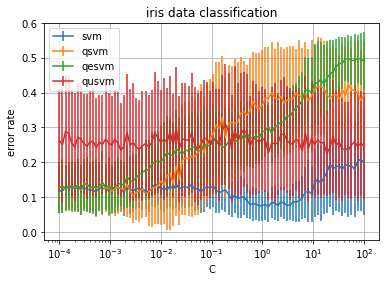

In [39]:
import matplotlib.pyplot as plt
plt.errorbar(C[:], err_mean[:, 0], yerr=err_std[:, 0], label='svm')
plt.errorbar(C[:], err_mean[:, 1], yerr=err_std[:, 1], label='qsvm')
plt.errorbar(C[:], err_mean[:, 2], yerr=err_std[:, 2], label='qesvm')
plt.errorbar(C[:], err_mean[:, 3], yerr=err_std[:, 3], label='qusvm')
plt.xscale('log')

plt.grid()
plt.legend()
plt.xlabel('C')
plt.ylabel('error rate')
plt.title('iris data classification')
plt.show()

#### Obtain optimal C values for each model and plot
* TSNE was used form visualizing support vectors.
* Too small or large C values were ignored

In [40]:
err_trc = np.array(err_mean, copy=True)
err_trc[C<=1e-3, :]=np.inf

optC1 = C[np.argmin(err_trc[:, 0])]
optC2 = C[np.argmin(err_trc[:, 1])]
optC3 = C[np.argmin(err_trc[:, 2])]
optC4 = C[np.argmin(err_trc[:, 3])]
print(optC1, optC2, optC3, optC4)

1.3219411484660273 0.0028480358684357995 0.0010722672220103248 18.738174228603835


iris data


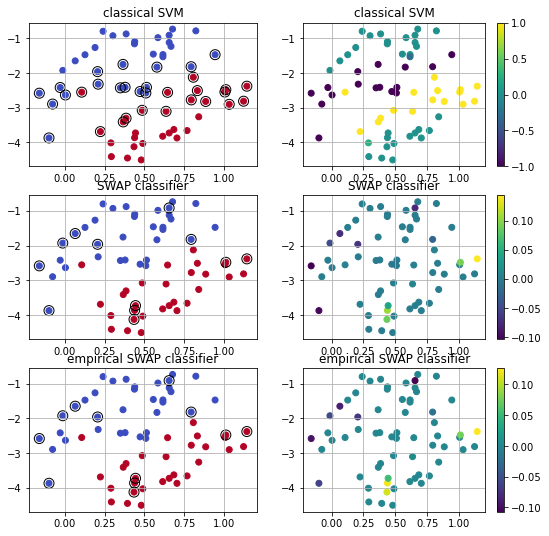

In [41]:
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from custom_qiskit.classifier import SVM
from custom_qiskit.pseudo_swap_classifier import pseudo_empirical_SWAP_classifier, pseudo_SWAP_classifier, pseudo_uniform_SWAP_classifier
from tqdm import tqdm, tqdm_notebook
from custom_qiskit.datageneration import sklearn_data

X, y, Xt, yt = sklearn_data('iris', 2**6, range(4), (1,2), 'nb')
option1='sv, tsne'
option2='density, tsne'
svm1 = SVM(X, y, C=optC1)
svm2 = SVM(X, y, C=optC2)
svm3 = SVM(X, y, C=optC3)svm4 = SVM(X, y, C=optC4)
x = np.random.rand(svm1.num_data)
svm1.optimize(x, maxiter=100, method='SLSQP')
svm2.optimize(x, maxiter=100, mimic='qsvm', method='SLSQP')
svm3.optimize(x, validation_data=Xt, validation_label=yt, maxiter=100, mimic='qesvm', method='SLSQP')
svm4.optimize(x, maxiter=100, mimic='qusvm', method='SLSQP')
Xe = svm1.tsne(50)
svm1.data_emb = Xe
svm2.data_emb = Xe
svm3.data_emb = Xe
fig, axes = plt.subplots(3, 2, figsize=(9, 9))
svm1.plot(axes=axes[0, 0], option=option1)
svm2.plot(axes=axes[1, 0], option=option1)
svm3.plot(axes=axes[2, 0], option=option1)
svm1.plot(axes=axes[0, 1], option=option2)
svm2.plot(axes=axes[1, 1], option=option2)
svm3.plot(axes=axes[2, 1], option=option2)
axes[0, 0].set_title('classical SVM')
axes[1, 0].set_title('SWAP classifier')
axes[2, 0].set_title('empirical SWAP classifier')
axes[0, 1].set_title('classical SVM')
axes[1, 1].set_title('SWAP classifier')
axes[2, 1].set_title('empirical SWAP classifier')
print('iris data')

Data points with positive weigh $\alpha$ have tendency to populate near borderline, and that tendency is strong in the order of *classical SVM > SWAP classifier > empirical SWAP classifier*.<br>
However, keep in mind that it is not always garanteed, for there are some randomness in sampling data, and for the data points have been transformed by TSNE.<br>
Finally, let's check performance of models.

In [43]:
print('Empirical correct probability of')
print('\tclassical SVM:                    {:.3%}'.format(svm1.check_performance(Xt, yt)))
print('\tSWAP gate classifier:             {:.3%}'.format(svm2.check_performance(Xt, yt)))
print('\tempirical SWAP gate classifier:   {:.3%}'.format(svm3.check_performance(Xt, yt)))
print('\tUniform SWAP classifier:          {:.3%}'.format(svm4.check_performance(Xt, yt)))
print('for iris dataset')

Empirical correct probability of
	classical SVM:                    97.222%
	SWAP gate classifier:             97.222%
	empirical SWAP gate classifier:   94.444%
	Uniform SWAP classifier:          75.000%
for iris dataset


### Compare performance/error rate of wine dataset
#### Observe regularization
* note on 'mimic' keyword: 'qsvm' ~ SWAP classifier, 'qesvm' ~ empirical SWAP classifier, 'qeusvm' ~ uniform SWAP classifier.
* wine dataset is loaded from **sklearn** library, where all labels are not seperable
* For the sake of computation speed and to observer effect of inequality constraint **without** effects of Entangler circuit, classical SVM modules with different optimization constraints are utilized.

In [57]:
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from custom_qiskit.classifier import SVM
from custom_qiskit.pseudo_swap_classifier import pseudo_empirical_SWAP_classifier, pseudo_SWAP_classifier, pseudo_uniform_SWAP_classifier
from tqdm import tqdm, tqdm_notebook
from custom_qiskit.datageneration import sklearn_data

def f(C):
    X, y, Xt, yt = sklearn_data('wine', 2**6, range(13), (1,2), 'nb')
    svm1 = SVM(X, y, C=C)
    svm2 = SVM(X, y, C=C)
    svm3 = SVM(X, y, C=C)
    svm4 = SVM(X, y, C=C)
    x = np.random.rand(svm1.num_data)
    svm1.optimize(x, maxiter=1000)
    svm2.optimize(x, maxiter=1000, mimic='qsvm')
    svm3.optimize(x, validation_data=X, validation_label=y, mimic='qesvm')
    svm4.optimize(x, maxiter=1000, mimic = 'qusvm')
    return [C, svm1.check_performance(Xt, yt), svm2.check_performance(Xt, yt), svm3.check_performance(Xt, yt), svm4.check_performance(Xt, yt)]

Cs = np.array([np.logspace(-4, 2, 100) for _ in range(100)]).reshape(-1)
if __name__=='__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        res = list(tqdm_notebook(pool.imap_unordered(f, tuple(Cs)), total=Cs.size))
res = sorted(res, key=lambda x:x[0])

a = np.array(np.array_split(res, 100))
err_mean = 1-a.mean(axis=1)[:, 1:5]
err_std = a.std(axis=1)[:, 1:5]
C = a.mean(axis=1)[:,0]

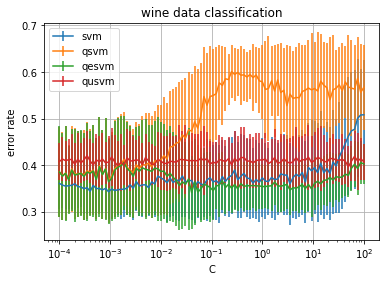

In [58]:
import matplotlib.pyplot as plt
plt.errorbar(C[:], err_mean[:, 0], yerr=err_std[:, 0], label='svm')
plt.errorbar(C[:], err_mean[:, 1], yerr=err_std[:, 1], label='qsvm')
plt.errorbar(C[:], err_mean[:, 2], yerr=err_std[:, 2], label='qesvm')
plt.errorbar(C[:], err_mean[:, 3], yerr=err_std[:, 3], label='qusvm')
plt.xscale('log')

plt.grid()
plt.legend()
plt.xlabel('C')
plt.ylabel('error rate')
plt.title('wine data classification')
plt.show()

In [59]:
err_trc = np.array(err_mean, copy=True)
err_trc[C<=1e-3, :]=np.inf

optC1 = C[np.argmin(err_trc[:, 0])]
optC2 = C[np.argmin(err_trc[:, 1])]
optC3 = C[np.argmin(err_trc[:, 2])]
optC4 = C[np.argmin(err_trc[:, 3])]
print(optC1, optC2, optC3, optC4)

0.001232846739442069 0.0010722672220103248 0.04037017258596543 49.77023564332106


wine data


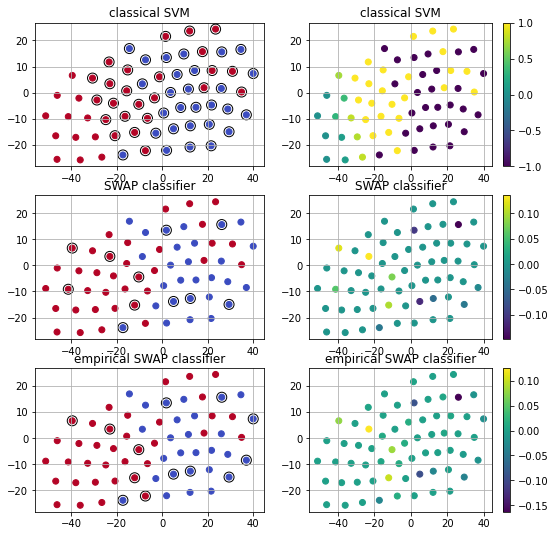

In [62]:
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from custom_qiskit.classifier import SVM
from custom_qiskit.pseudo_swap_classifier import pseudo_empirical_SWAP_classifier, pseudo_SWAP_classifier, pseudo_uniform_SWAP_classifier
from tqdm import tqdm, tqdm_notebook
from custom_qiskit.datageneration import sklearn_data

X, y, Xt, yt = sklearn_data('wine', 2**6, range(13), (1,2), 'nb')
option1='sv, tsne'
option2='density, tsne'
svm1 = SVM(X, y, C=optC1)
svm2 = SVM(X, y, C=optC2)
svm3 = SVM(X, y, C=optC3)
svm4 = SVM(X, y, C=optC4)
x = np.random.rand(svm1.num_data)
svm1.optimize(x, maxiter=100, method='SLSQP')
svm2.optimize(x, maxiter=100, mimic='qsvm', method='SLSQP')
svm3.optimize(x, validation_data=Xt, validation_label=yt, maxiter=100, mimic='qesvm', method='SLSQP')
svm4.optimize(x, maxiter=100, mimic='qusvm', method='SLSQP')
Xe = svm1.tsne(50)
svm1.data_emb = Xe
svm2.data_emb = Xe
svm3.data_emb = Xe
fig, axes = plt.subplots(3, 2, figsize=(9, 9))
svm1.plot(axes=axes[0, 0], option=option1)
svm2.plot(axes=axes[1, 0], option=option1)
svm3.plot(axes=axes[2, 0], option=option1)
svm1.plot(axes=axes[0, 1], option=option2)
svm2.plot(axes=axes[1, 1], option=option2)
svm3.plot(axes=axes[2, 1], option=option2)
axes[0, 0].set_title('classical SVM')
axes[1, 0].set_title('SWAP classifier')
axes[2, 0].set_title('empirical SWAP classifier')
axes[0, 1].set_title('classical SVM')
axes[1, 1].set_title('SWAP classifier')
axes[2, 1].set_title('empirical SWAP classifier')
print('wine data')

In [63]:
print('Empirical correct probability of')
print('\tclassical SVM:                    {:.3%}'.format(svm1.check_performance(Xt, yt)))
print('\tSWAP gate classifier:             {:.3%}'.format(svm2.check_performance(Xt, yt)))
print('\tempirical SWAP gate classifier:   {:.3%}'.format(svm3.check_performance(Xt, yt)))
print('\tUniform SWAP classifier:          {:.3%}'.format(svm4.check_performance(Xt, yt)))
print('for wine dataset')

Empirical correct probability of
	classical SVM:                    58.182%
	SWAP gate classifier:             65.455%
	empirical SWAP gate classifier:   56.364%
	Uniform SWAP classifier:          63.636%
for wine dataset


In [19]:
print(f'total execution time: {time.time()-__START} s')

total execution time: 1417.5492775440216 s


### Compare performance/error rate of SWAP classifier
* compare models with entangling quantum circuit as weight encoding circuit with classical SVM
* effect of limited search space which is range of encoding circuit will be vividly shown.

In [20]:
# TODO